In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Direct Token Importance

/tmp/ipython-input-172982939.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(encoded["attention_mask"])[0]


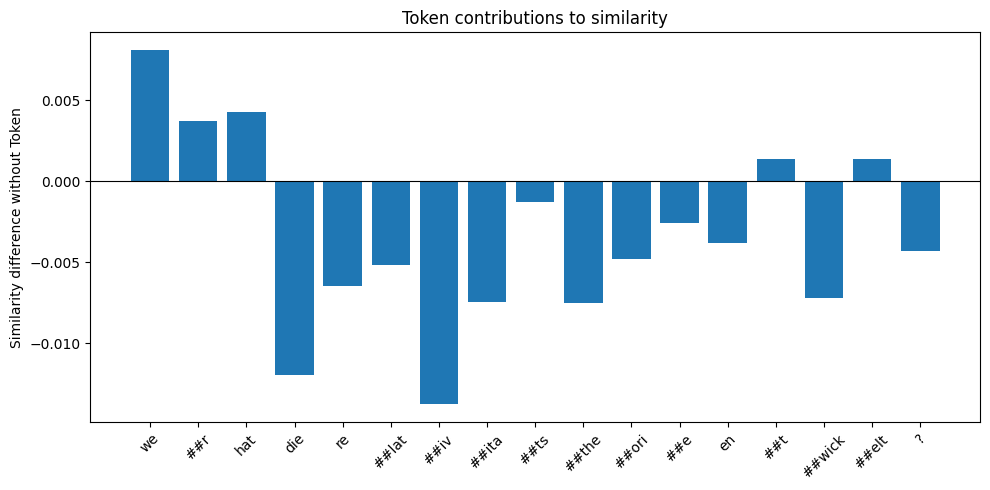

In [3]:
from sentence_transformers import SentenceTransformer, util
import torch
import matplotlib.pyplot as plt

model = SentenceTransformer("all-MiniLM-L6-v2").to(device)

query = "Wer hat die Relativitätstheorie entwickelt?"
doc = "Albert Einstein entwickelte die Relativitätstheorie."

encoded = model.tokenize([query])
token_embeddings = model.encode(query, output_value="token_embeddings", convert_to_tensor=True).squeeze(0).cpu()
attention_mask = torch.tensor(encoded["attention_mask"])[0]
tokens = model.tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])

# mean pooling (on outputs)
def mean_pooling(token_embeddings, attention_mask):
    mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
    return (token_embeddings * mask_expanded).sum(0) / mask_expanded.sum(0)

# full query embedding
emb_full = mean_pooling(token_embeddings, attention_mask)

# similarity between doc and full query
emb_doc = model.encode(doc, convert_to_tensor=True).cpu()
sim_full = util.cos_sim(emb_full, emb_doc).item()

# different similarites with token masking (masking in the outbut so that contextawerness during embedding isn't lost)
contributions = {}
for i, tok in enumerate(tokens):
    if tok in ["[CLS]", "[SEP]"]:
        continue

    mask_new = attention_mask.clone()
    mask_new[i] = 0  # Mask Token

    emb_sub = mean_pooling(token_embeddings, mask_new)
    sim_sub = util.cos_sim(emb_sub, emb_doc).item()
    contributions[tok] = sim_sub - sim_full

# plot
plt.figure(figsize=(10,5))
plt.bar(contributions.keys(), contributions.values())
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Similarity difference without Token")
plt.title("Token contributions to similarity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Lime (surrogate model)

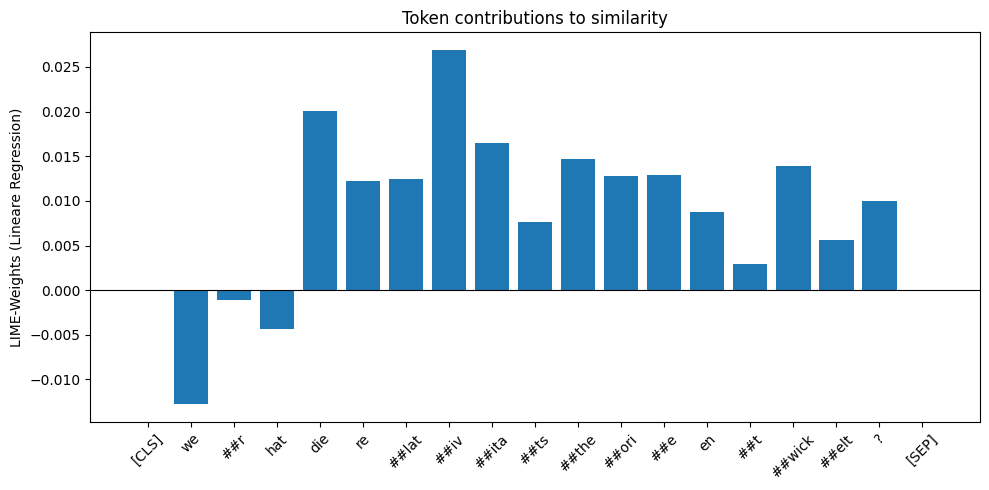

In [6]:
from itertools import product
from sklearn.linear_model import LinearRegression


tokens_core = tokens[1:-1]  # remove CLS/SEP
n_tokens = token_embeddings.size(0)
n_core = len(tokens_core)

# linear regression dataset (subsets, similarity)
X, y = [], []

# plot helpers
subset_embeddings = []
masked = []

# creating all binary (with or without token - 2^tokens) subsets
for bits in product([0,1], repeat=n_core):
    mask = torch.ones(n_tokens)
    mask[1:-1] = torch.tensor(bits)

    emb_subset = mean_pooling(token_embeddings, mask)
    sim = util.cos_sim(emb_subset, emb_doc).item()
    subset_embeddings.append(emb_subset.cpu().numpy())

    X.append(mask.cpu().numpy())
    y.append(sim)

    masked_tokens = [tok for tok, b in zip(tokens_core, bits) if b==0]
    masked.append(", ".join(masked_tokens) if masked_tokens else "None")


reg = LinearRegression().fit(X, y)
coefs = reg.coef_

# Plot
plt.figure(figsize=(10,5))
plt.bar(tokens, coefs)
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("LIME-Weights (Lineare Regression)")
plt.title("Token contributions to similarity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
import plotly.express as px
import numpy as np
from itertools import product
from sklearn.decomposition import PCA

np.random.seed(42)

similarities = np.array(y)
subset_embeddings = np.array(subset_embeddings)
masked = np.array(masked)

# Choose examples
idx_max = np.argmax(similarities)
idx_min = np.argmin(similarities)
idx_median = np.argsort(similarities)[len(similarities)//2]
idx_random = np.random.choice(len(similarities), size=2, replace=False)

selected_idx = [idx_max, idx_median, idx_min] + list(idx_random)

coords_selected = subset_embeddings[selected_idx]
labels_selected = masked[selected_idx]
sims_selected = similarities[selected_idx]

# PCA
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(coords_selected)
doc_2d = pca.transform(emb_doc.cpu().numpy().reshape(1,-1))


# query subsets
fig = px.scatter(
    x=coords_2d[:,0],
    y=coords_2d[:,1],
    color=sims_selected,
    hover_name=labels_selected,
    color_continuous_scale="RdYlBu",
    size=[15]*len(coords_2d),
    title="Token contributions to similarity",
    labels={"color": "Similarity"}
)

# document
fig.add_scatter(
    x=[doc_2d[0,0]],
    y=[doc_2d[0,1]],
    mode="markers+text",
    marker=dict(color="black", size=20, symbol="x"),
    text=doc,
    textposition="top center",
    name="Document"
)

fig.show()
